In [10]:
import sys
import os
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'

import floatpy.readers.padeops_reader as por
import floatpy.readers.parallel_reader as pdr
import floatpy.utilities.reduction as red
import floatpy.derivatives.compact.compact_derivative as cd
import statistics as stats

dtheta_inc = 0.018

# Thicknesses
dtheta = {0.7: 0.535240772247}
print(dtheta.keys())
print(dtheta.values())

[0.7]
[0.535240772247]


Text(0,0.5,'$\\delta/\\delta_{inc}$')

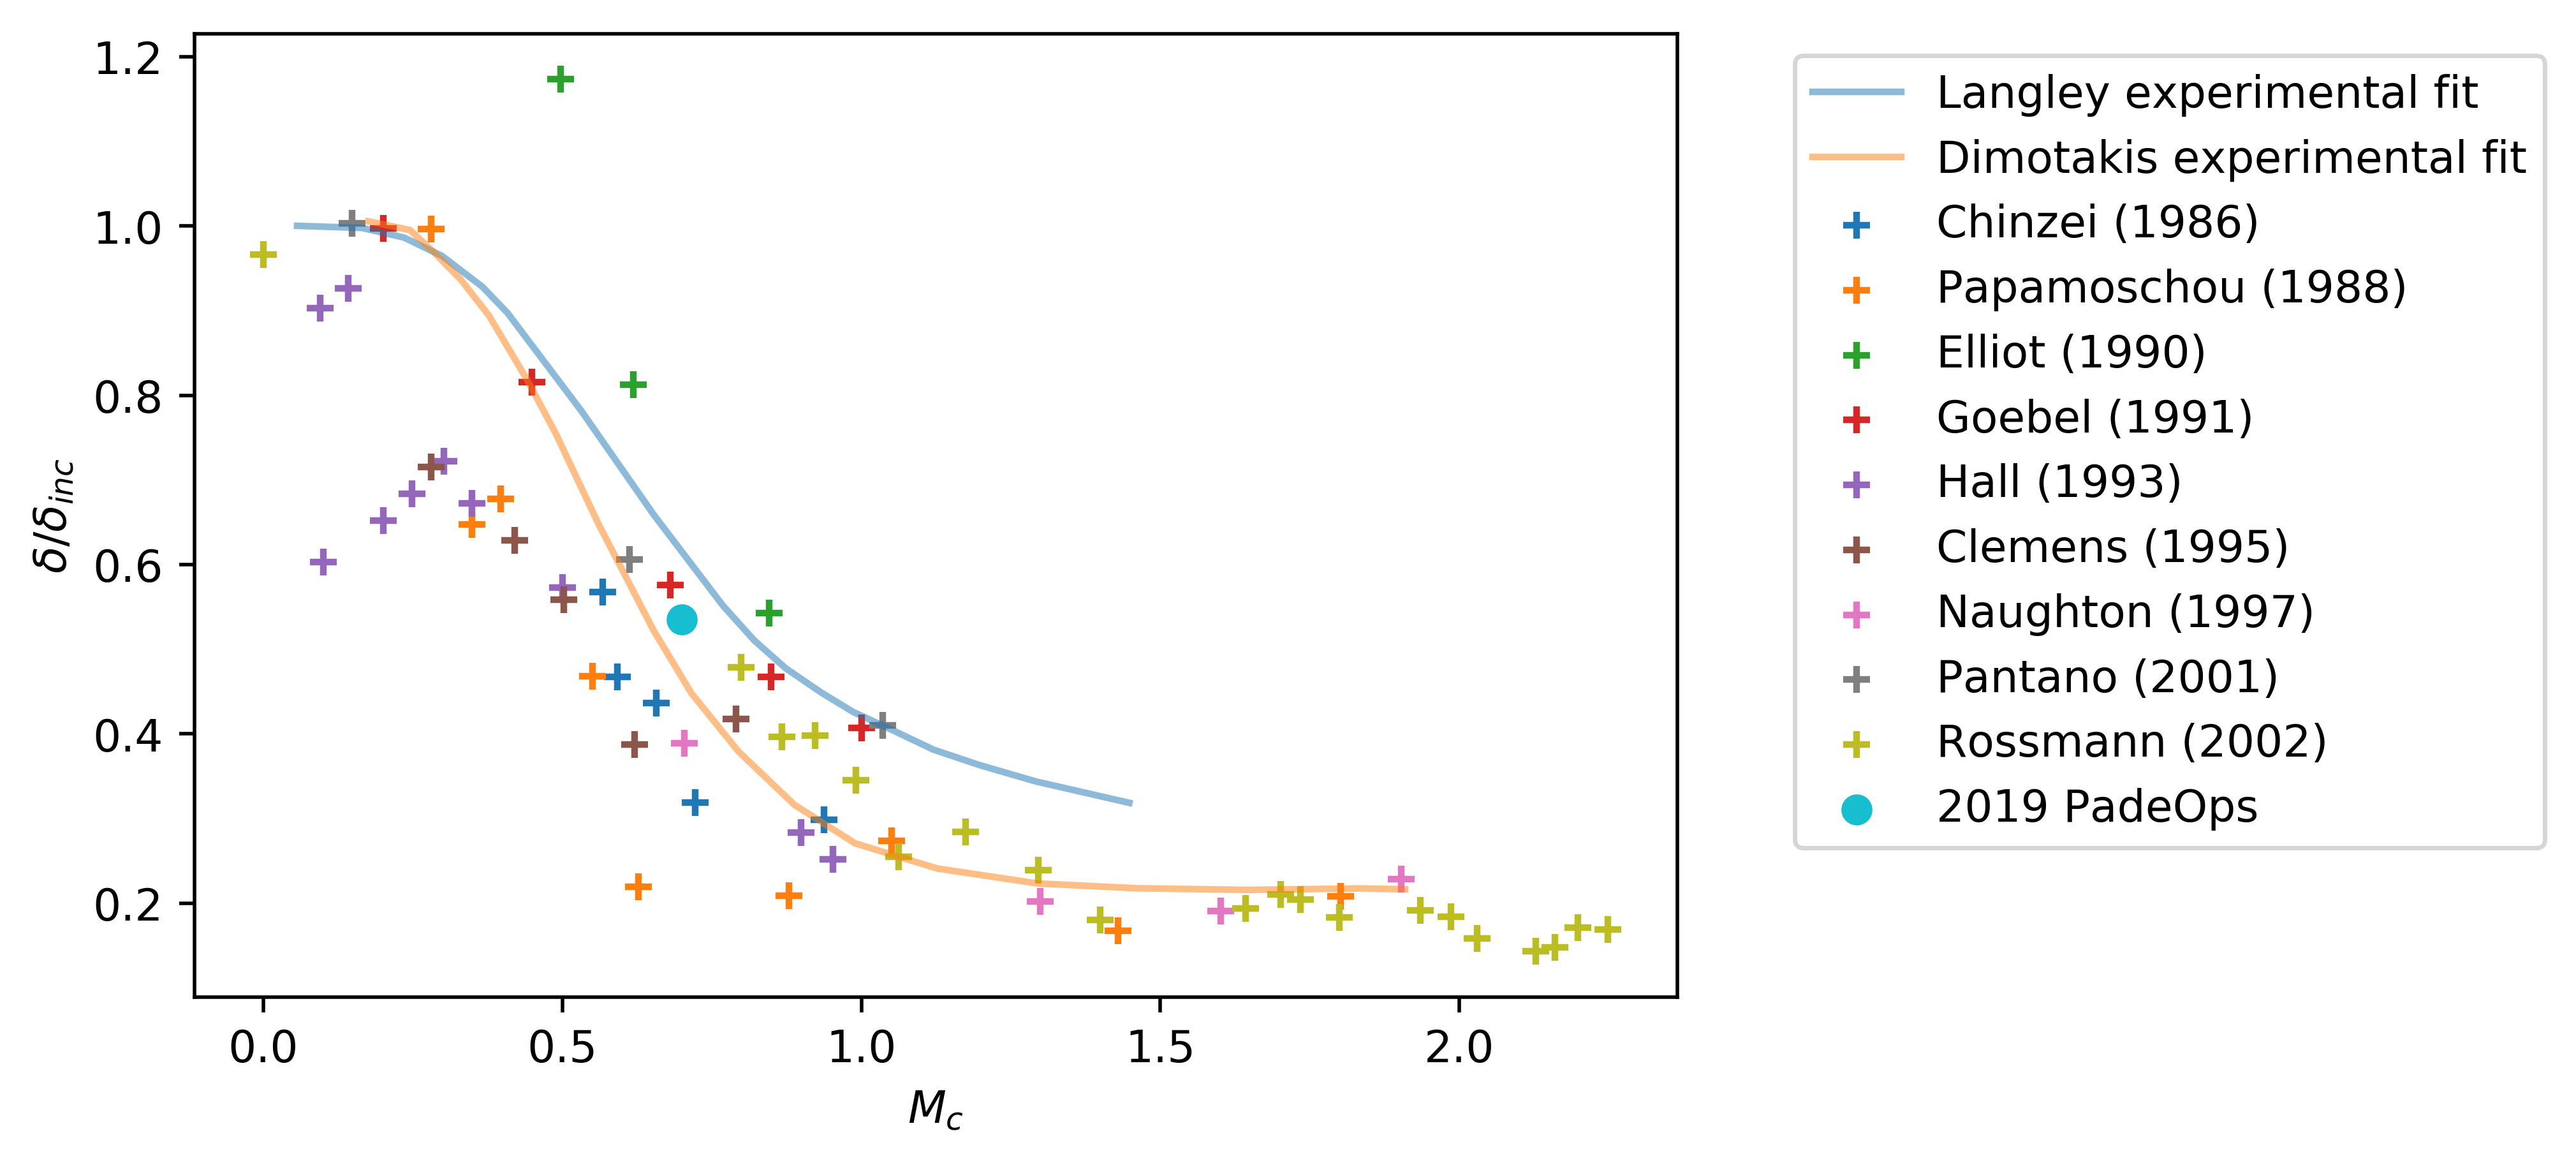

In [12]:
# Literature comparison
def read_data(fname):
    dat = np.fromfile('/home/kmatsuno/FloATPy/post/lit/'+fname,dtype=float, count=-1, sep=' ')
    dat = np.array(dat)
    n = np.size(dat)/2
    dat = np.reshape(dat,[n,2])
    return dat[:,0],dat[:,1]

def get_files(path):
    for file in os.listdir(path):
        if os.path.isfile(os.path.join(path, file)):
            yield file
            
plt.figure(figsize=(6,4),dpi=500)

            
# Experimental fit
Mc,growth=read_data('fits/Langley')
plt.plot(Mc,growth,alpha=0.5,label='Langley experimental fit')
Mc,growth=read_data('fits/Dimotakis')
plt.plot(Mc,growth,alpha=0.5,label='Dimotakis experimental fit')

# data files
files = [f for f in get_files('/home/kmatsuno/FloATPy/post/lit/')]
years = [f[-4::] for f in files]
file_dict = {}
for i in range(len(files)):
    auth,year = files[i].split('_')
    file_dict[year] = auth

# Plot, sorted by year
for year in sorted(years):
    auth = file_dict[year]
    Mc,growth = read_data(auth+'_'+year)
    plt.scatter(Mc,growth,marker='+',label=auth + ' ('+year+')')

# PadeOps data:
plt.scatter(dtheta.keys(),dtheta.values(),marker='o',label='2019 PadeOps')
plt.legend(bbox_to_anchor=(1.6, 1.0))
plt.xlabel('$M_c$')
plt.ylabel('$\delta/\delta_{inc}$')
